In [1]:
%matplotlib inline
from matplotlib import pyplot as plt 
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_name = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [3]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4915, 0.4823, 0.4468),
            (0.2470, 0.2435, 0.2616)
        )
    ])
)

Files already downloaded and verified


In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4915, 0.4823, 0.4468),
            (0.2470, 0.2435, 0.2616)
        )
    ])
)

Files already downloaded and verified


In [5]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
        for img, label in cifar10
        if label in [0, 2]]

cifar2_val = [(img, label_map[label])
        for img, label in cifar10_val
        if label in [0, 2]]

In [6]:
connected_model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2)
)

In [7]:
numel_list = [p.numel() # Returns the total number of elements in the input tensor.
            for p in connected_model.parameters()
            if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [8]:
first_model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

In [9]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [10]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [11]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [12]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [13]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

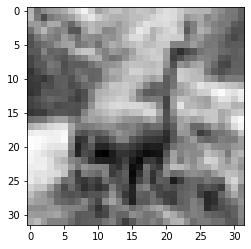

In [14]:
# Returns the mean value of all elements in the input tensor.
plt.imshow(img.mean(0), cmap='gray')
plt.show()

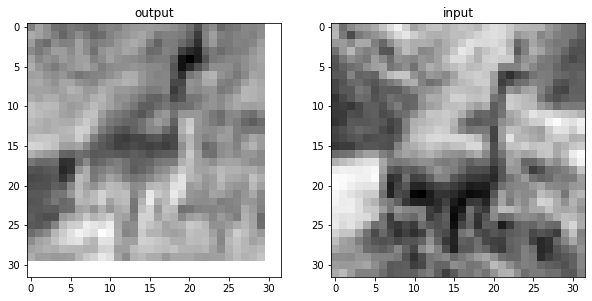

In [15]:
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
# con2d之后的图像，w，h变小了
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.savefig('Ch8_F2_PyTorch.png')
plt.show()


In [16]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1) # with padding
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [17]:
with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0) # Fills self tensor with the specified value.

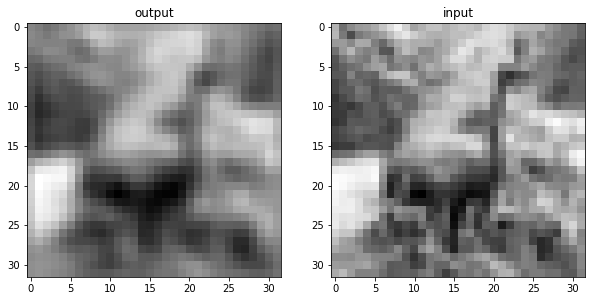

In [18]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.savefig('Ch8_F4_PyTorch.png')
plt.show()

In [19]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([
        [-1.0, 0.0, 1.0],
        [-1.0, 0.0, 1.0],
        [-1.0, 0.0, 1.0]
    ])
    conv.bias.zero_()

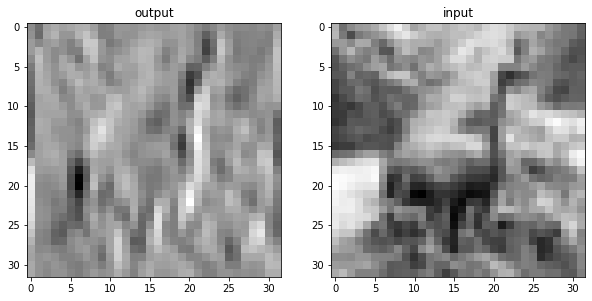

In [20]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex= ax1, sharey = ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.savefig('Ch8_F5_PyTorch.png')
plt.show()

In [21]:
# downsampling 
pool = nn.MaxPool2d(2) # half of img
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [22]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
)

In [23]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

In [24]:
model

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Tanh()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Tanh()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Linear(in_features=512, out_features=32, bias=True)
  (7): Tanh()
  (8): Linear(in_features=32, out_features=2, bias=True)
)

In [25]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

# 5，6层之间形状不对
model(img.unsqueeze(0))

In [26]:
class Net(nn.Module):
    # 初始化模型
    def __init__(self):
        super().__init__() # 使用父类所有方法
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [27]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [28]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [29]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0157,  0.1143]], grad_fn=<AddmmBackward>)

In [30]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:

            outputs = model(imgs)

            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, loss_train / len(train_loader)
            ))

In [31]:
# 开始训练
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net() # 实例化模型
optimizer = optim.SGD(model.parameters(), lr = 1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
)

2020-10-27 17:46:40.707345 Epoch 1, Training loss 0.5634810890361761
2020-10-27 17:46:47.582818 Epoch 10, Training loss 0.3277621578638721
2020-10-27 17:46:55.180270 Epoch 20, Training loss 0.30351272196906387
2020-10-27 17:47:02.759225 Epoch 30, Training loss 0.2825085948796789
2020-10-27 17:47:10.301848 Epoch 40, Training loss 0.2611393540338346
2020-10-27 17:47:17.912904 Epoch 50, Training loss 0.2410738201467854
2020-10-27 17:47:25.617024 Epoch 60, Training loss 0.22000028425531024
2020-10-27 17:47:33.364954 Epoch 70, Training loss 0.20374622148503163
2020-10-27 17:47:40.185158 Epoch 80, Training loss 0.1894119463054238
2020-10-27 17:47:46.824028 Epoch 90, Training loss 0.1728621991291927
2020-10-27 17:47:54.097665 Epoch 100, Training loss 0.1614482874987991


In [32]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # Returns a namedtuple (values, indices)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print('accuracy {}: {:.2f}'.format(name, correct / total))

validate(model, train_loader, val_loader)

accuracy train: 0.93
accuracy val: 0.89


In [33]:
# 保存模型
# 只保存 weight 和 bias
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [34]:
# 加载模型
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

In [35]:
device = (torch.device('cuda') if torch.cuda.is_available()
else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [36]:
# 将数据放到gpu上训练
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:

            imgs = imgs.to(device=device)
            labels = labels.to(device=device)

            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 ==0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [37]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle=True)

model = Net().to(device=device) # gpu
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100, 
    optimizer=optimizer,
    loss_fn=loss_fn,
    model=model,
    train_loader=train_loader,
)

2020-10-27 17:48:57.907200 Epoch 1, Training loss 0.5717792224352527
2020-10-27 17:48:59.640826 Epoch 10, Training loss 0.3285275893226551
2020-10-27 17:49:01.564645 Epoch 20, Training loss 0.2949430201273815
2020-10-27 17:49:03.486984 Epoch 30, Training loss 0.26964475214481354
2020-10-27 17:49:05.399588 Epoch 40, Training loss 0.24710934015975636
2020-10-27 17:49:07.310876 Epoch 50, Training loss 0.22624936982230015
2020-10-27 17:49:09.222629 Epoch 60, Training loss 0.2099768923251492
2020-10-27 17:49:11.135430 Epoch 70, Training loss 0.19350984426820353
2020-10-27 17:49:13.048893 Epoch 80, Training loss 0.17992867529392242
2020-10-27 17:49:14.968861 Epoch 90, Training loss 0.16622693471278355
2020-10-27 17:49:16.888856 Epoch 100, Training loss 0.15665086230654626


In [38]:
# 验证中的东西也要放到gpu上
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)
all_act_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)

                outpus = model(imgs)
                _, predicted = torch.max(outpus, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        
        print("accuracy {}: {:.2f}".format(name, correct/total))
        accdict[name] = correct / total
    
    return accdict

all_act_dict["baseline"] = validate(model, train_loader, val_loader)


accuracy train: 0.93
accuracy val: 0.89


In [39]:
# 防止模型导入时parm在不同的cpu，gpu上
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt', map_location=device))

<All keys matched successfully>

In [40]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out 

In [41]:
model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer= optimizer,
    model = model,
    loss_fn=loss_fn,
    train_loader=train_loader,
)

validate(model, train_loader, val_loader)

2020-10-27 17:50:06.025506 Epoch 1, Training loss 0.5696581562233579
2020-10-27 17:50:08.033040 Epoch 10, Training loss 0.32219540038306244
2020-10-27 17:50:10.257836 Epoch 20, Training loss 0.2805871392131611
2020-10-27 17:50:12.483133 Epoch 30, Training loss 0.24590190409854717
2020-10-27 17:50:14.708959 Epoch 40, Training loss 0.21835067360454305
2020-10-27 17:50:16.941291 Epoch 50, Training loss 0.19438091176710312
2020-10-27 17:50:19.156272 Epoch 60, Training loss 0.17157918143614082
2020-10-27 17:50:21.398487 Epoch 70, Training loss 0.14896330607544844
2020-10-27 17:50:23.630331 Epoch 80, Training loss 0.12718237101272412
2020-10-27 17:50:25.861178 Epoch 90, Training loss 0.10674886258354613
2020-10-27 17:50:28.089044 Epoch 100, Training loss 0.08838534486853773
accuracy train: 0.96
accuracy val: 0.89


{'train': 0.963, 'val': 0.8895}

In [42]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [43]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100, 
    optimizer = optimizer,
    model = model, 
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_act_dict["width"] = validate(model, train_loader, val_loader)

2020-10-27 17:51:06.003437 Epoch 1, Training loss 0.5444508238582854
2020-10-27 17:51:08.031437 Epoch 10, Training loss 0.3170700021989786
2020-10-27 17:51:10.276322 Epoch 20, Training loss 0.2745387403258852
2020-10-27 17:51:12.504257 Epoch 30, Training loss 0.24255863448996454
2020-10-27 17:51:14.732502 Epoch 40, Training loss 0.21337010573809315
2020-10-27 17:51:16.960308 Epoch 50, Training loss 0.1869511068531662
2020-10-27 17:51:19.186874 Epoch 60, Training loss 0.1631440440560602
2020-10-27 17:51:21.417709 Epoch 70, Training loss 0.1408410418043091
2020-10-27 17:51:23.639674 Epoch 80, Training loss 0.11990224033783956
2020-10-27 17:51:25.861505 Epoch 90, Training loss 0.10069689966121297
2020-10-27 17:51:28.091970 Epoch 100, Training loss 0.08321491784303431
accuracy train: 0.96
accuracy val: 0.90


In [44]:
# 参数增加代表模型能力变强，但是更加容易过拟合
sum(p.numel() for p in model.parameters())

38386

In [45]:
# 正则化（降低过拟合）
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device = device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            # 正则化超参数
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() # p的平方和 L2正则化
                        for p in model.parameters())
            
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, loss_train / len(train_loader)
            ))

In [46]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr = 1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs=100, 
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_act_dict["l2 reg"] = validate(model, train_loader, val_loader)

2020-10-27 17:51:41.188888 Epoch 1, Training loss 0.5842778845957131
2020-10-27 17:51:43.782025 Epoch 10, Training loss 0.366337840249584
2020-10-27 17:51:46.665491 Epoch 20, Training loss 0.3225773044262722
2020-10-27 17:51:49.520152 Epoch 30, Training loss 0.296157845076482
2020-10-27 17:51:52.414895 Epoch 40, Training loss 0.27756449352404117
2020-10-27 17:51:55.301963 Epoch 50, Training loss 0.26362315142989917
2020-10-27 17:51:58.189379 Epoch 60, Training loss 0.25154368474984623
2020-10-27 17:52:01.079320 Epoch 70, Training loss 0.24004859837946618
2020-10-27 17:52:03.966544 Epoch 80, Training loss 0.229327915153306
2020-10-27 17:52:06.847501 Epoch 90, Training loss 0.21893906095035517
2020-10-27 17:52:09.736112 Epoch 100, Training loss 0.20912677690291862
accuracy train: 0.90
accuracy val: 0.87


In [47]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        # During training, randomly zeroes some of the elements of the input tensor with probability p using samples from a                Bernoulli distribution.
        self.conv1_dropout = nn.Dropout2d(p = 0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2,kernel_size=3,padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out 

In [48]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100, 
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_act_dict["dropout"] = validate(model, train_loader, val_loader)

2020-10-27 17:52:24.947036 Epoch 1, Training loss 0.5800064297238733
2020-10-27 17:52:27.117473 Epoch 10, Training loss 0.3807507089938328
2020-10-27 17:52:29.510555 Epoch 20, Training loss 0.34909636152398055
2020-10-27 17:52:31.894926 Epoch 30, Training loss 0.3297840468822771
2020-10-27 17:52:34.281859 Epoch 40, Training loss 0.3125590352685588
2020-10-27 17:52:36.686032 Epoch 50, Training loss 0.29206441504180813
2020-10-27 17:52:39.099559 Epoch 60, Training loss 0.2820613627221174
2020-10-27 17:52:41.516976 Epoch 70, Training loss 0.27233606425060586
2020-10-27 17:52:43.926191 Epoch 80, Training loss 0.2628108785030948
2020-10-27 17:52:46.341336 Epoch 90, Training loss 0.25364449420931995
2020-10-27 17:52:48.758016 Epoch 100, Training loss 0.23999611112722166
accuracy train: 0.89
accuracy val: 0.88


In [49]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [50]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_act_dict["batch_norm"] = validate(model, train_loader, val_loader)

2020-10-27 17:53:12.254305 Epoch 1, Training loss 0.47399359542852754
2020-10-27 17:53:14.700656 Epoch 10, Training loss 0.25992414715943063
2020-10-27 17:53:17.396848 Epoch 20, Training loss 0.1945777485609814
2020-10-27 17:53:20.093615 Epoch 30, Training loss 0.1442410928333641
2020-10-27 17:53:22.791405 Epoch 40, Training loss 0.10276865384950759
2020-10-27 17:53:25.481416 Epoch 50, Training loss 0.0674566314881964
2020-10-27 17:53:28.166451 Epoch 60, Training loss 0.04050419429779812
2020-10-27 17:53:30.851330 Epoch 70, Training loss 0.0429234330892373
2020-10-27 17:53:33.538759 Epoch 80, Training loss 0.017211677589613922
2020-10-27 17:53:36.221521 Epoch 90, Training loss 0.010823181622726902
2020-10-27 17:53:38.907298 Epoch 100, Training loss 0.007121785057435749
accuracy train: 1.00
accuracy val: 0.88


In [51]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out 

In [52]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model= model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

all_act_dict["depth"] = validate(model, train_loader, val_loader)

2020-10-27 17:54:04.420645 Epoch 1, Training loss 0.6548043470473806
2020-10-27 17:54:06.892539 Epoch 10, Training loss 0.3400014505075042
2020-10-27 17:54:09.964863 Epoch 20, Training loss 0.30154374564529224
2020-10-27 17:54:13.040884 Epoch 30, Training loss 0.2728621114021654
2020-10-27 17:54:15.697748 Epoch 40, Training loss 0.24442388259681166
2020-10-27 17:54:18.270979 Epoch 50, Training loss 0.21723966831993904
2020-10-27 17:54:20.851153 Epoch 60, Training loss 0.19132162891565616
2020-10-27 17:54:23.430421 Epoch 70, Training loss 0.1674400788678485
2020-10-27 17:54:26.008994 Epoch 80, Training loss 0.14456504341333534
2020-10-27 17:54:28.587175 Epoch 90, Training loss 0.12120718819795141
2020-10-27 17:54:31.167465 Epoch 100, Training loss 0.0982655059000489
accuracy train: 0.96
accuracy val: 0.90


In [53]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out # skip
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out
        

In [54]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer = optimizer, 
    model = model, 
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_act_dict['res'] = validate(model, train_loader, val_loader)

2020-10-27 17:54:46.244513 Epoch 1, Training loss 0.6650018969159217
2020-10-27 17:54:48.611064 Epoch 10, Training loss 0.3292901647888171
2020-10-27 17:54:51.228349 Epoch 20, Training loss 0.2862075178106879
2020-10-27 17:54:53.839989 Epoch 30, Training loss 0.25521448719653356
2020-10-27 17:54:56.451866 Epoch 40, Training loss 0.2279798646641385
2020-10-27 17:54:59.063869 Epoch 50, Training loss 0.2016522283576856
2020-10-27 17:55:01.805578 Epoch 60, Training loss 0.1760909477853851
2020-10-27 17:55:04.893440 Epoch 70, Training loss 0.1513449186399864
2020-10-27 17:55:07.972153 Epoch 80, Training loss 0.1264056845265589
2020-10-27 17:55:10.670162 Epoch 90, Training loss 0.10043424866191901
2020-10-27 17:55:13.294270 Epoch 100, Training loss 0.07885381177210124
accuracy train: 0.96
accuracy val: 0.90


In [55]:
# 深层网络中的一小块
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5) # Fills the input Tensor with the value \text{val}val .
        torch.nn.init.zeros_(self.batch_norm.bias) # Fills the input Tensor with the scalar value 0.

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [61]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1 = 32,  n_blocks = 10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding = 1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans = n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out 

In [62]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr = 3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader=train_loader,
)

all_act_dict['res deep'] = validate(model, train_loader, val_loader)

2020-10-27 19:03:07.223764 Epoch 1, Training loss 1.4996130836617416
2020-10-27 19:03:56.333438 Epoch 10, Training loss 0.3086315898378943
2020-10-27 19:04:51.358291 Epoch 20, Training loss 0.2117100392177606
2020-10-27 19:05:46.535146 Epoch 30, Training loss 0.14944075344569363
2020-10-27 19:06:41.866359 Epoch 40, Training loss 0.11774772360541258
2020-10-27 19:07:37.213343 Epoch 50, Training loss 0.07389695913038531
2020-10-27 19:08:32.614792 Epoch 60, Training loss 0.15944417614703346
2020-10-27 19:09:28.150938 Epoch 70, Training loss 0.028523778782380375
2020-10-27 19:10:23.689352 Epoch 80, Training loss 0.03368857453108593
2020-10-27 19:11:19.306736 Epoch 90, Training loss 0.015992638726190778
2020-10-27 19:12:15.063215 Epoch 100, Training loss 0.012264126194173849
accuracy train: 0.99
accuracy val: 0.87


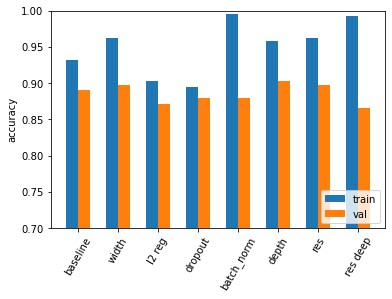

In [63]:
trn_acc = [v['train'] for k, v in all_act_dict.items()]
val_acc = [v['val'] for k, v in all_act_dict.items()]

width = 0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc)) + width/2, list(all_act_dict.keys()), rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()